In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev, InterpolatedUnivariateSpline
import datetime as dt
import matplotlib.pyplot as plt
import json
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [161]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T


def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    if 't' not in data.columns:
        data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                   np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

def stretch_simulated_feats(data, stretch,true_feats = ['Vx','Vy','Vz'],
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

def amp_sim_feats(data, amp_stretch,true_feats = ['Vx','Vy','Vz'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        data[feature+suffix] = amp_stretch*data[feature+'_stretch']
    
    return data

In [6]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

In [5]:
s_data = pd.read_csv('./data/train.csv', index_col= 'id')

In [7]:
s_data_test = pd.read_csv('./data/test.csv', index_col= 'id')

In [20]:
s_track_1 = list(s_data_test['sat_id'].unique())
s_track_2 = [k for k in range(600) if k not in s_track_1]

In [21]:
data = get_satellite_data(s_data, 0)
#data.tail()

In [22]:
data_rtjf = remove_time_jumps_fast(data)
#data_rtjf.tail()

In [12]:
#run for all satellites and print sat id if error occurs
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|██████████| 600/600 [00:07<00:00, 83.42it/s] 


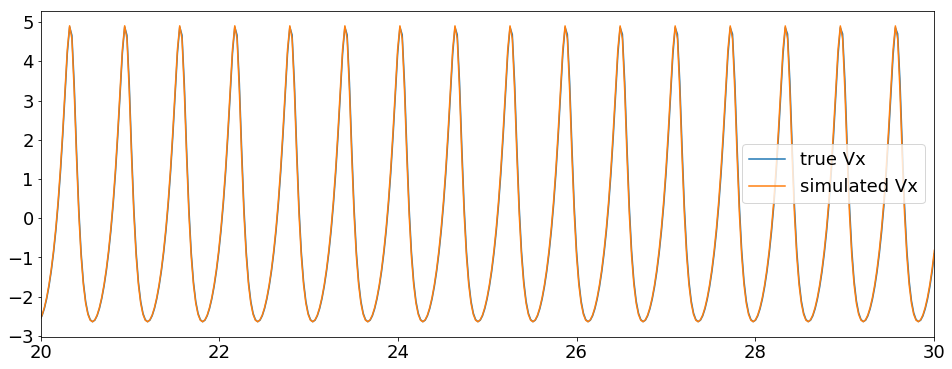

In [13]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 4))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

#plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

## Explore time scale stretch for simulations

The same stretch coefficient appears to work well for all dimensions

In [11]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

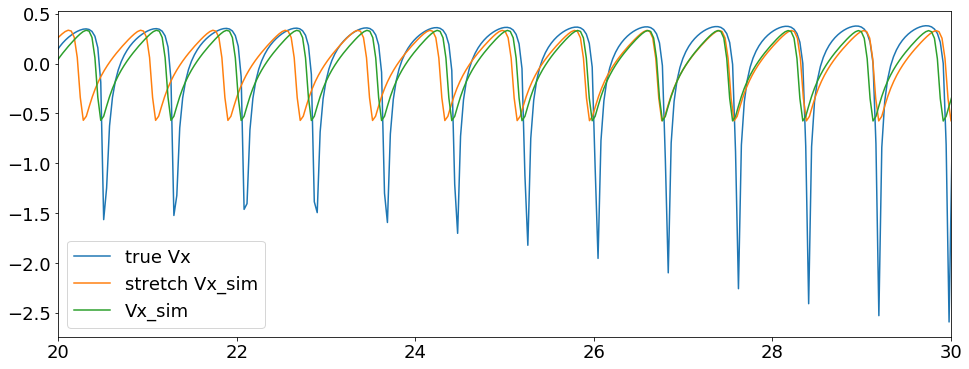

In [12]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 530))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(1.03*data['t'],data['Vz_sim'], label = 'stretch Vx_sim');
plt.plot(data['t'],data['Vz_sim'], label = 'Vx_sim');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

In [13]:
smape(data[true_feats].to_numpy(),data[sim_feats].to_numpy())

0.2805457851994837

In [14]:
data = stretch_simulated_feats(data,1.05)
smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())

0.6869481884255387

In [19]:
stretch_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

100%|██████████| 600/600 [00:32<00:00, 18.56it/s]


In [23]:
extreme_stretch = {k for k,v in stretch_dict.items() if (v <= 0.98 or v >= 1.02)}

In [30]:
for sat in extreme_stretch:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.94,1.06,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

In [31]:
for sat in extreme_stretch:
    print(sat,stretch_dict[sat])

35 1.02
260 1.02
515 1.0550000000000002
391 1.04
140 1.02
556 0.97
277 0.975
26 0.98
252 0.95


In [32]:
stretch_dict = {int(k):v for k,v in stretch_dict.items()}

#save stretch_dict
import json
with open('stretch_dict.txt', 'w') as file:
    json.dump(stretch_dict, file)

#with open('stretch_dict.txt', 'r') as file:
#    stretch_dict = json.load(file)


## Amplitude stretch

In [42]:
# satellite 391 needs amplitude stretched
with open('stretch_dict.txt', 'r') as file:
    stretch_dict = json.load(file) #keys as strings
stretch_dict = {int(k) : v for k,v in stretch_dict.items()}
stretch_dict[391]

1.04

In [47]:
amp_dict = {dim: {} for dim in ['x','y','z']}
for dim in ['x','y','z']:
    for sat in s_data['sat_id'].unique():
        amplitude_list = []
        for i in np.arange(0.97,1.03,0.005):
            data = stretch_simulated_feats(data,stretch_dict[sat])
            data = amp_sim_feats(data,i)
            metric = smape(data[true_feats].to_numpy(),data[stretch_amp_feats].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict[dim][sat] = best[0]

In [111]:
s_data.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [124]:
amp_dict = {dim: {} for dim in ['x','y','z']}
for dim in ['x','y','z']:
    for sat in range(600):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict[sat])
            data = amp_sim_feats(data,i)
            metric = smape(data['V{}'.format(dim)].to_numpy(),data['V{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict[dim][sat] = best[0]

In [133]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'x': [26, 115, 277, 310, 442, 572],
 'y': [26,
  162,
  164,
  249,
  277,
  301,
  353,
  404,
  442,
  459,
  490,
  511,
  515,
  517,
  572],
 'z': [26,
  28,
  37,
  104,
  109,
  179,
  209,
  244,
  248,
  277,
  322,
  396,
  455,
  481,
  515,
  530,
  556,
  572]}

In [134]:
for dim in ['x','y','z']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.05):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict[sat])
            data = amp_sim_feats(data,i)
            metric = smape(data['V{}'.format(dim)].to_numpy(),data['V{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict[dim][sat] = best[0]

In [136]:
extreme_amp2 = {}
for dim in ['x','y','z']:
    extreme_amp2[dim] = [k for k,v in amp_dict[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp2

{'x': [], 'y': [], 'z': []}

In [137]:
for dim in ['x','y','z']:
    amp_dict[dim] = {int(k):v for k,v in amp_dict[dim].items()}
#save stretch_dict
import json
with open('amp_dict.txt', 'w') as file:
    json.dump(amp_dict, file)

#with open('amp_dict.txt', 'r') as file:
#    amp_dict = json.load(file)


### Transform test data (track 1)
1. Remove time jumps
2. Stretch (horizontal)
3. Stretch amplitude (vertical) for each dimension

In [182]:
s_data_test = pd.read_csv('./data/test.csv', index_col= 'id')
s_data_test['t'] = ((pd.to_datetime(s_data_test['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
s_data_test.columns

Index(['sat_id', 'epoch', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim', 't'],
      dtype='object')

In [183]:
df_list = [get_satellite_data(s_data_test,i) for i in s_track_1]

In [184]:
#remove time jumps
for df in df_list:
    df = remove_time_jumps_fast(df)

In [185]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict[int(df['sat_id'].unique())])

In [186]:
#amplitude stretch
for df in df_list:
    for dim in ['x','y','z']:
        amp = amp_dict[dim][int(df['sat_id'].unique())]
        df['V{}'.format(dim)] = amp*df['V{}_stretch'.format(dim)]
        
#predicted velocities 

In [228]:
#predict coordinates using equation of motion
for df in df_list:
    for dim in ['x','y','z']:      
        df[dim] = np.nan
        x1 = df.iloc[1,df.columns.get_loc('{}_sim'.format(dim))]
        #print(x1)
        x0 = df.iloc[0,df.columns.get_loc('{}_sim'.format(dim))]
        #print(x0)
        v1 = df.iloc[1,df.columns.get_loc('V{}'.format(dim))]
        #print(v1)
        v0 = df.iloc[0,df.columns.get_loc('V{}'.format(dim))]
        #print(v0)
        df.iloc[0, df.columns.get_loc(dim)] = x0
        df.iloc[1, df.columns.get_loc(dim)] = x1-x0
        alpha = (x1-x0)/(v1+v0)
        df[dim+'_diff'] = alpha*df['V{}'.format(dim)].diff()
        a, a_diff = df[dim].iloc[0], df[dim+'_diff'].iloc[1:]
        df[dim] = np.r_[a, a_diff].cumsum()

In [230]:
submission = pd.concat(df_list)
submission_columns = ['x','y','z','Vx','Vy','Vz']
submission = submission[submission_columns]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [231]:
submission = submission.set_index(s_data_test.index)

In [232]:
submission.head(10)

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.651198,0.826990
3928,-12893.100705,-13405.808443,6057.765264,5.077413,0.338972,0.319670
3929,-12611.671463,-12102.466496,5493.632956,5.519106,1.892060,-0.550201
3930,-13038.500953,-10267.520122,4613.720861,4.849212,4.078618,-1.906992
3931,-14891.812950,-8805.060021,3755.018231,1.940505,5.821314,-3.231079
3932,-17213.773313,-9209.261233,3697.668963,-1.703730,5.339660,-3.319509
3933,-18458.493678,-10615.442187,4208.618541,-3.657275,3.664027,-2.531644
3934,-18831.254168,-11892.012863,4751.167260,-4.242309,2.142841,-1.695055
3935,-18811.579916,-12846.770464,5187.951830,-4.211431,1.005133,-1.021549


In [233]:
submission.to_csv("sub_baseline.csv",index=True)

In [234]:
sub_baseline = pd.read_csv('sub_baseline.csv',index_col='id')
sub_baseline.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.651198,0.826990
3928,-12893.100705,-13405.808443,6057.765264,5.077413,0.338972,0.319670
3929,-12611.671463,-12102.466496,5493.632956,5.519106,1.892060,-0.550201
3930,-13038.500953,-10267.520122,4613.720861,4.849212,4.078618,-1.906992
3931,-14891.812950,-8805.060021,3755.018231,1.940505,5.821314,-3.231079


In [147]:
#sample submission

sub = pd.read_csv('./data/submission.csv', index_col= 'id')
sub.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


## Finding peaks and valleys (max/min)

Find zeros first, subdivide time by zeros of velocity, then max or min for each interval.

In [71]:
#Find zeros:
t = data['t']
x = data['Vx']
spl = InterpolatedUnivariateSpline(t, x)
spl.roots()

array([ 0.04993235,  0.5367329 ,  0.83759385,  1.32500676,  1.62602085,
        2.11325585,  2.4144107 ,  2.90147985,  3.20272896,  3.689679  ,
        3.99094656,  4.47785088,  4.77905078,  5.2659962 ,  5.56704375,
        6.05411324,  6.35494374,  6.84219946,  7.14278215,  7.63025133,
        7.93060383,  8.41826579,  8.71845366,  9.20623962,  9.50638048,
        9.99416953, 10.29443332, 10.78205353, 11.08265393, 11.56988842,
       11.87105366, 12.35767223, 12.65959719, 13.14540383, 13.44819628,
       13.93308451, 14.23673928, 14.7207117 , 15.02512225, 15.50828502,
       15.81328628, 16.29580423, 16.60121112, 17.08326901, 17.38890591,
       17.87067739, 18.17639221, 18.65803053, 18.96369758, 19.44532645,
       19.75085045, 20.23256344, 20.53787779, 21.01973874, 21.32480998,
       21.80685046, 22.11167698, 22.59389577, 22.89851129, 23.38086963,
       23.68534566, 24.16776858, 24.47221444, 24.95458745, 25.25915438,
       25.74132252, 26.04620442, 26.52797372, 26.83341544, 27.31

In [49]:
def best_stretch_coefficient(data, threshold = 0.05, iterations = 100,
                            true_feats = ['x','y','z','Vx','Vy','Vz']):
    '''
    find stretch coefficient that yields best smape for given satellite
    iterations: max number of iterations
    
    '''
    